# Stateful LSTM using TensorFlow

## What is stateful LSTM?

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam

from data_preprocess import X, y, num_train_samples, num_val_samples, num_test_samples

import numpy as np
import matplotlib.pyplot as plt

num_train_samples: 252270
num_val_samples: 84090
num_test_samples: 84091


In [2]:
num_features = X.shape[1]
print('Number of features:', num_features)

Number of features: 14


## Data Loader for Stateful-LSTM

In [3]:
import numpy as np

i = 5
j = 3

# Tensorflow version = 2.4.1
int_sequence = np.arange(100)
dummy_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=int_sequence[:-20],
    targets=int_sequence[20:],
    sequence_length=i,
    sequence_stride=1,   # Default = 1
    sampling_rate=j,     # Default = 1
    batch_size=i*j,
    shuffle=False
)

# 텐서플로우 버전에 따라 함수 클래스가 다릅니다. (최신 버전의 경우 아래 함수 사용)
# dummy_dataset = tf.keras.utils.timeseries_dataset_from_array(
#     data=int_sequence[:-3],
#     targets=int_sequence[3:],
#     sequence_length=3,
#     batch_size=2
# )

for inputs, targets in dummy_dataset:
    # inputs shape : (batch_size, sequence_length)
    # targets shape : (batch_size, )
    print("====================")
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 3, 6, 9, 12] 20
[1, 4, 7, 10, 13] 21
[2, 5, 8, 11, 14] 22
[3, 6, 9, 12, 15] 23
[4, 7, 10, 13, 16] 24
[5, 8, 11, 14, 17] 25
[6, 9, 12, 15, 18] 26
[7, 10, 13, 16, 19] 27
[8, 11, 14, 17, 20] 28
[9, 12, 15, 18, 21] 29
[10, 13, 16, 19, 22] 30
[11, 14, 17, 20, 23] 31
[12, 15, 18, 21, 24] 32
[13, 16, 19, 22, 25] 33
[14, 17, 20, 23, 26] 34
[15, 18, 21, 24, 27] 35
[16, 19, 22, 25, 28] 36
[17, 20, 23, 26, 29] 37
[18, 21, 24, 27, 30] 38
[19, 22, 25, 28, 31] 39
[20, 23, 26, 29, 32] 40
[21, 24, 27, 30, 33] 41
[22, 25, 28, 31, 34] 42
[23, 26, 29, 32, 35] 43
[24, 27, 30, 33, 36] 44
[25, 28, 31, 34, 37] 45
[26, 29, 32, 35, 38] 46
[27, 30, 33, 36, 39] 47
[28, 31, 34, 37, 40] 48
[29, 32, 35, 38, 41] 49
[30, 33, 36, 39, 42] 50
[31, 34, 37, 40, 43] 51
[32, 35, 38, 41, 44] 52
[33, 36, 39, 42, 45] 53
[34, 37, 40, 43, 46] 54
[35, 38, 41, 44, 47] 55
[36, 39, 42, 45, 48] 56
[37, 40, 43, 46, 49] 57
[38, 41, 44, 47, 50] 58
[39, 42, 45, 48, 51] 59
[40, 43, 46, 49, 52] 60
[41, 44, 47, 50, 53] 61
[42, 45, 48, 5

2023-02-03 12:05:57.284133: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-03 12:05:57.284632: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-03 12:05:57.373559: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


**To use `stateful=True` mode in LSTM (RNN), you should follow the rules below:**

- Do **NOT** shuffle the dataset
- `sequence_stride` $\times$ `batch_size` = `sequence_length` $\times$ `sampling_rate`
- Each batch need to have the same number of samples, i.e., the number of samples needs to divisible by `batch_size`.

In [4]:
# Observations will be sampled at one data point per hour
sampling_rate = 6

# Observations will go back 5 days (120 hours)
sequence_length = 120

# The target for a sequence will be the temperature 24 hours after the end of the sequence.
delay = sampling_rate * (sequence_length + 24 - 1)

batch_size = sampling_rate*sequence_length

train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=X[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    sequence_stride=1,
    shuffle=False,
    batch_size=batch_size,
    start_index=271,
    end_index=num_train_samples
    )

val_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=X[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    sequence_stride=1,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples+571,
    end_index=num_train_samples + num_val_samples
    )

test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=X[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    sequence_stride=1,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples+434,
    end_index=None
    )

## Stateful LSTM model

- To use stateful mode in LSTM, we need to specify the batch size in Input layer.

In [5]:
input_tensor = Input(shape=(sequence_length, num_features), batch_size=batch_size)
x = LSTM(units=16, return_sequences=False, stateful=True)(input_tensor)
x = Dense(units=1, activation=None)(x)

model = Model(inputs=input_tensor, outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss='mse', metrics=['mse'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(720, 120, 14)]          0         
_________________________________________________________________
lstm (LSTM)                  (720, 16)                 1984      
_________________________________________________________________
dense (Dense)                (720, 1)                  17        
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.fit(train_dataset, epochs=30, validation_data=val_dataset)

Epoch 1/30
349/349 [==============================] - 61s 170ms/step - loss: 122.0367 - mse: 122.0367 - val_loss: 44.4674 - val_mse: 44.4674
Epoch 2/30
349/349 [==============================] - 55s 157ms/step - loss: 47.0625 - mse: 47.0625 - val_loss: 26.7192 - val_mse: 26.7192
Epoch 3/30
349/349 [==============================] - 54s 156ms/step - loss: 30.2891 - mse: 30.2891 - val_loss: 18.9408 - val_mse: 18.9408
Epoch 4/30
349/349 [==============================] - 56s 161ms/step - loss: 22.5730 - mse: 22.5730 - val_loss: 15.2152 - val_mse: 15.2152
Epoch 5/30
349/349 [==============================] - 55s 157ms/step - loss: 18.0913 - mse: 18.0913 - val_loss: 13.2435 - val_mse: 13.2435
Epoch 6/30
349/349 [==============================] - 55s 157ms/step - loss: 15.2648 - mse: 15.2648 - val_loss: 12.0580 - val_mse: 12.0580
Epoch 7/30
349/349 [==============================] - 55s 159ms/step - loss: 13.5215 - mse: 13.5215 - val_loss: 11.3727 - val_mse: 11.3727
Epoch 8/30
349/349 [=====

In [7]:
test_targets = np.empty([0])
print(test_targets)

for data in test_dataset:
    test_targets = np.append(test_targets, data[1])

test_num = test_targets.shape[0]
print(test_num)

[]
82080


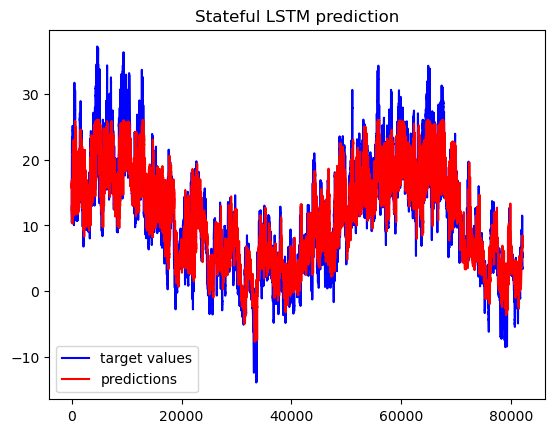

In [8]:
predictions = model.predict(test_dataset)
predictions = predictions.reshape((test_num,))

x = np.arange(test_num)
plt.plot(x, test_targets, label = 'target values', color='b')
plt.plot(x, predictions, label = 'predictions', color='r')
plt.title('Stateful LSTM prediction')
plt.legend()
plt.show()

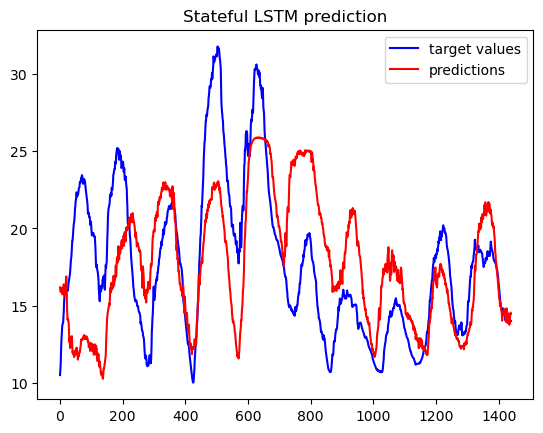

In [10]:
x = np.arange(1440)
plt.plot(x, test_targets[:1440], label = 'target values', color='b')
plt.plot(x, predictions[:1440], label = 'predictions', color='r')
plt.title('Stateful LSTM prediction')
plt.legend()
plt.show()

## Future Works

Compare between stateful LSTM with `shorter sequence length` and that with `longer sequence length`.